In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import os
import matplotlib.pyplot as plt
from matplotlib import pylab
import emoji
import re
import contractions
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import tensorflow_hub as hub
import tokenization
from tensorflow import keras
from kerastuner.tuners import RandomSearch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<IPython.core.display.Javascript object>

In [39]:
%config IPCompleter.greedy=True
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Constants
curr_dir = ".."
train_file = os.path.join(curr_dir, "dataset", "train.csv")
test_file = os.path.join(curr_dir, "dataset", "test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (16, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set_theme(style="darkgrid")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
df = pd.read_csv(train_file)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
def plotBarGraph(data, labelx, labely, title, switch_axis=False):
    y = data.index.tolist()
    x = data.tolist()
    if switch_axis:
        x = data.index.tolist()
        y = data.tolist()
    sns.barplot(y=y, x=x)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

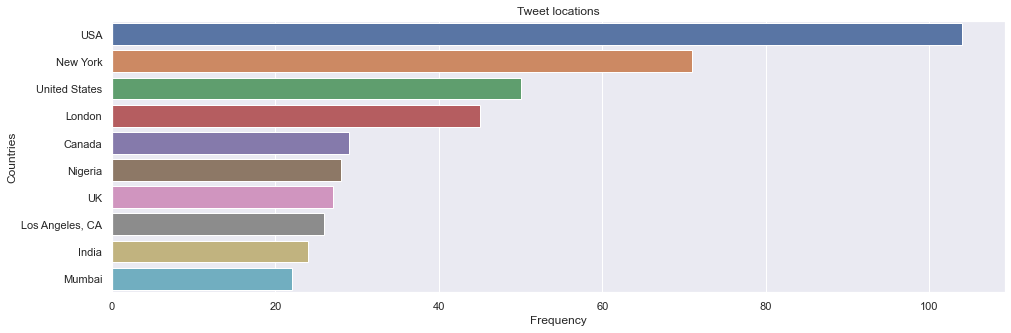

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
locations_map = df.location.value_counts().sort_values(ascending=False)[:10]
plotBarGraph(locations_map, "Frequency", "Countries", "Tweet locations")

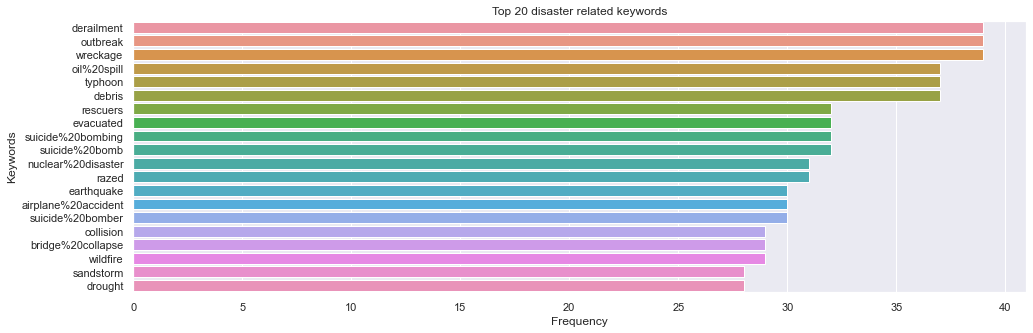

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Top 20 Disaster related Keywords
keywords_map = (
    df.keyword.loc[df.target == 1].value_counts().sort_values(ascending=False)[:20]
)
plotBarGraph(keywords_map, "Frequency", "Keywords", "Top 20 disaster related keywords")

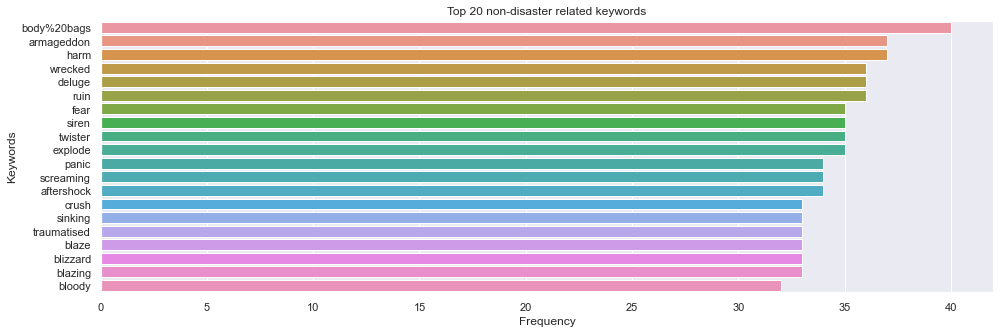

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# Top 20 Non-Disaster related Keywords
keywords_non_disaster_map = df.keyword.loc[df.target == 0].value_counts(
    ascending=False
)[:20]
plotBarGraph(
    keywords_non_disaster_map,
    "Frequency",
    "Keywords",
    "Top 20 non-disaster related keywords",
)

In [49]:
print(
    "In the graphs(Top 20 disaster keywords and non-disaster keywords) above\n we see that disaster keywords are natural or artificial calamilites.\nWhile non-disaster keywords are too generalized keywords and not sufficient to describe a disaster."
)

In the graphs(Top 20 disaster keywords and non-disaster keywords) above
 we see that disaster keywords are natural or artificial calamilites.
While non-disaster keywords are too generalized keywords and not sufficient to describe a disaster.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

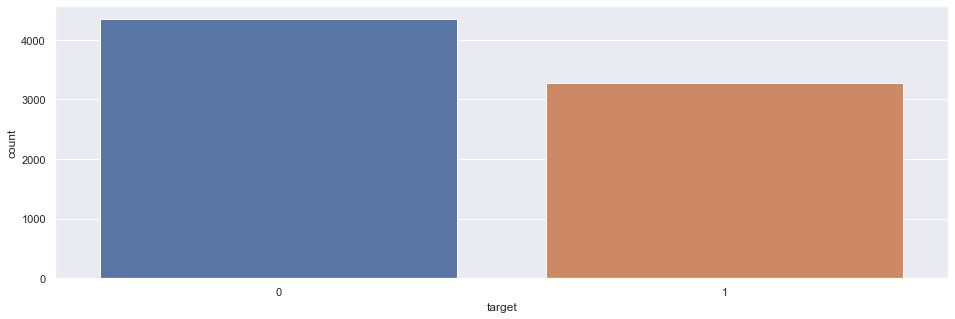

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
sns.countplot(x="target", data=df)
plt.show()

False    7503
True      110
Name: text, dtype: int64


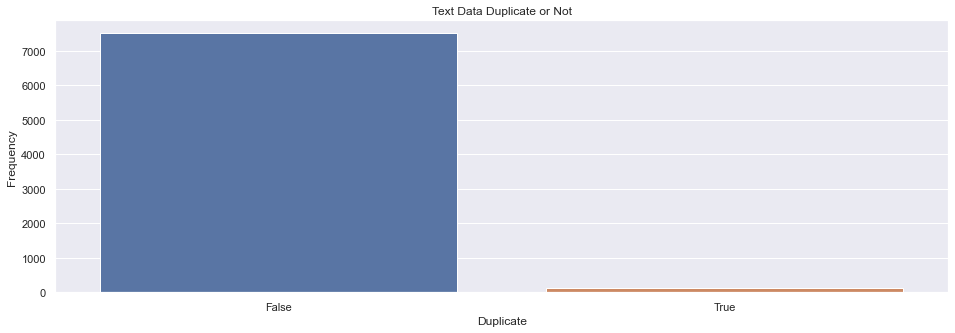

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Removing Duplicate Text Data
text_data_duplicate_map = df.text.duplicated().value_counts()
print(text_data_duplicate_map)
plotBarGraph(
    text_data_duplicate_map,
    "Duplicate",
    "Frequency",
    "Text Data Duplicate or Not",
    switch_axis=True,
)

In [52]:
print("Original dataframe shape: ", df.shape)
df.drop_duplicates(subset="text", keep="first", inplace=True)
print("Dropping duplicate rows and keeping original value shape: ", df.shape)
df.text.duplicated().value_counts()

Original dataframe shape:  (7613, 5)
Dropping duplicate rows and keeping original value shape:  (7503, 5)


False    7503
Name: text, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
def search_text_data(query, column="text"):
    return df[df[column].str.contains(query)][column]


print(search_text_data("volcano")[:5])

1368    @POTUS Would you please explain what you are g...
3041    #SCSeEstaPreparando Light mag. 4.4 earthquake ...
4714    The sunset looked like an erupting volcano ......
6771    Maybe that's what happens when a tornado meets...
7126    Jetstar and Virgin forced to cancel Bali fligh...
Name: text, dtype: object


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# Lower case text data
def lower_case_data(data=""):
    data = data.lower()
    return data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# Handle Emojis
def sentences_with_emojis(id_texts):
    sentences = []
    indeces = id_texts[0]
    texts = id_texts[1]
    for index, sentence in zip(indeces, texts):
        has_emoji = bool(emoji.get_emoji_regexp().search(sentence))
        if has_emoji:
            sentences.append((index, sentence))
    if len(sentences) == 0:
        return "Sentences are clean and don't have emojis!"
    else:
        return sentences


# Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def clean_emojis(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = " ".join(
        [str for str in text.split() if not any(i in str for i in emoji_list)]
    )
    return clean_text

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# Clean urls
def clean_urls(text):
    text = re.sub(r"https?://\S+", "", text)
    return text

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# Remove all sorts of special characters and punctuations.
def removeSpecialChar(text):
    sentence = []
    for s in text:
        if s == " ":
            sentence.append(s)
        if s.isalnum():
            sentence.append(s)
    return "".join(sentence)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# Check any html text in df.text (not cleaned yet) column
def checkHtml(text):
    return bool(BeautifulSoup(text, "html.parser").find())


html_sentence_map = df["text"].apply(checkHtml).tolist()
if not any(html_sentence_map):
    print("No text containing html found!")
else:
    print("There is some html text!")

No text containing html found!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# Remove accented text
def remove_accented_chars(text):
    new_text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )
    return new_text

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
# Explore Stopwords list from nltk
def remove_words_having_not(words=[""]):
    for word in words:
        if "not" in word:
            words.remove(word)
    return words


stopwords_list = stopwords.words("english")
print(stopwords_list)
stopwords_list = remove_words_having_not(
    [removeSpecialChar(contractions.fix(word)) for word in stopwords_list]
)
print("\n---------------Stopwords after preprocessing---------------\n")
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
# Remove stopwords from nltk corpus
def remove_stopwords(text):
    new_sentence = ""
    for word in text.split():
        if word not in stopwords_list:
            new_sentence += word + " "
    return new_sentence

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
# Remove numbers from text
def remove_numbers(text=""):
    new_sentence = ""
    for word in text.split():
        num_free_word = "".join([i for i in word if not i.isdigit()])
        new_sentence += num_free_word + " "
    return new_sentence

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
# lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    new_sentence = ""
    for word in text.split():
        lematized_word = lemmatizer.lemmatize(word)
        new_sentence += lematized_word + " "
    return new_sentence

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
# Final data cleaning step is removing non-essential whitespaces
def remove_white_space(text):
    return " ".join(text.split())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
# Text cleaning pipeline
def clean_sentence_pipeline(text):
    text = lower_case_data(text)
    text = clean_emojis(text)
    text = clean_urls(text)
    text = contractions.fix(text)
    text = removeSpecialChar(text)
    text = remove_accented_chars(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = lemmatize(text)
    return remove_white_space(text)


def clean_text_column(col_name):
    df["clean_text"] = ""
    df["clean_text"] = df[col_name].apply(clean_sentence_pipeline)


clean_text_column("text")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
# Comparison of cleaned texts
df[["text", "clean_text"]]

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,worldnews fallen powerlines glink tram update ...
7605,on the flip side I'm at Walmart and there is a...,flip side I walmart bomb everyone evacuate sta...
7606,Suicide bomber kills 15 in Saudi security site...,suicide bomber kill saudi security site mosque...
7608,Two giant cranes holding a bridge collapse int...,two giant crane holding bridge collapse nearby...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
# Bert Model Implementation
"""
BERT: Bidirectional Encoder Representations from Transformers

Vocab:
a. Masked Language Model: Mask random words in a sentence(fill in the blanks) 
    to understand bidirectional context.
b. Next sentence prediction: Two sentences and detect which sentences follows each other.

Process:
Token inputs -> BERT Transformer Encoders -> Output as next sentence prediction and mask language modeling
-> Pass to feedforward for classification.

1. Token Inputs
To generate token inputs, we need token embeddings(WordPiece Embedding) + Segment Embeddings(distinguish sentences)
+ Position Embeddings(position of word within a sentence encoded as a vector).

token embeddings: [CLS] token in the beginning of the sentence and [SEP] token at the end of the sentence
segment embeddings: distinguish sentences with tokens assigned to each sentence
position embedding: unique tokens assigned to each word in the sentence.
 
"""


"""
Embedding space=> Map words in sentence to a word cluster(embedding space)(Glove) to generate a vector for the word
Positional Encoder=> Context of the word with respect to the sentence vector
Embedding space + Positional encoding = encoding of word with context= EC

Encoder Block:feed input ("The red dog")
EC -> Multi-headed attention layer -> Feed forward layer

Attention layer: How relavent is the ith word  with respect to the other words in the same sentence
Feed forward nets: pass attention vectors into a simple neural net

Decoder Block: feed output ("le red chein")
Take the EC of output
EC -> multi-headed attention -> multi headed attention(encoded-decoded attention mapping(English to french translation happens here)
-> Feed foward layer -> linear -> softmax 

"""

'\nEmbedding space=> Map words in sentence to a word cluster(embedding space)(Glove) to generate a vector for the word\nPositional Encoder=> Context of the word with respect to the sentence vector\nEmbedding space + Positional encoding = encoding of word with context= EC\n\nEncoder Block:feed input ("The red dog")\nEC -> Multi-headed attention layer -> Feed forward layer\n\nAttention layer: How relavent is the ith word  with respect to the other words in the same sentence\nFeed forward nets: pass attention vectors into a simple neural net\n\nDecoder Block: feed output ("le red chein")\nTake the EC of output\nEC -> multi-headed attention -> multi headed attention(encoded-decoded attention mapping(English to french translation happens here)\n-> Feed foward layer -> linear -> softmax \n\n'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
# Bert config
bert_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True
)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
# test tokenizer
tokenizer.tokenize("covid-19 sucks like hell!")

['co', '##vid', '-', '19', 'sucks', 'like', 'hell', '!']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
MAX_SEQUENCE_LENGTH = 128


def build_model(hp):
    input_word_ids = keras.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids"
    )
    input_mask = keras.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask"
    )
    segment_ids = keras.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="segment_ids"
    )

    pooled_output, sequence_output = bert_layer(
        [input_word_ids, input_mask, segment_ids]
    )
    clf_output = sequence_output[:, 0, :]
    neural_inputs = keras.layers.Dense(
        hp.Int("units", min_value=32, max_value=512, step=32, default=128),
        activation="elu",
        kernel_initializer="he_normal",
    )(clf_output)
    neural_inputs = tf.keras.layers.Dropout(
        hp.Float("dropout", min_value=0, max_value=0.9, default=0.2, step=0.1)
    )(neural_inputs)
    neural_inputs = keras.layers.Dense(
        hp.Int("units", min_value=32, max_value=512, step=32, default=64),
        activation="elu",
        kernel_initializer="he_normal",
    )(neural_inputs)
    neural_inputs = tf.keras.layers.Dropout(
        hp.Float("dropout", min_value=0, max_value=0.9, default=0.2, step=0.1)
    )(neural_inputs)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(neural_inputs)
    model = tf.keras.models.Model(
        inputs=[input_word_ids, input_mask, segment_ids], outputs=out
    )
    model.compile(
        tf.keras.optimizers.Adam(hp.Choice("learning_rate", [5e-5, 3e-5, 2e-5])),
        loss=keras.losses.binary_crossentropy,
        metrics=["accuracy"],
    )

    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=3,
    project_name="../hyperparameter/random_search",
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>